In [30]:
import numpy as np
import pandas as pd
import yfinance as yf

In [31]:
stock_symbol = 'RELIANCE.NS'
stock_data = yf.download(stock_symbol,  period="max")

[*********************100%%**********************]  1 of 1 completed


In [32]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,14.638248,14.716795,14.541850,14.691803,9.302442,52060684
1996-01-02,14.656100,14.727506,14.470444,14.577553,9.230104,84371654
1996-01-03,14.816763,15.491551,14.656100,14.688232,9.300182,104661939
1996-01-04,14.548991,14.595404,14.356194,14.552561,9.214276,108450132
1996-01-05,14.495436,14.495436,14.327632,14.452592,9.150981,83354233
...,...,...,...,...,...,...
2024-04-25,2885.000000,2935.949951,2883.000000,2919.949951,2919.949951,7971963
2024-04-26,2927.899902,2930.000000,2900.000000,2905.100098,2905.100098,4706924
2024-04-29,2900.000000,2935.800049,2900.000000,2930.050049,2930.050049,3623987


In [33]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


stock_data.reset_index(inplace=True)

# Extract the 'Date' and 'Close' columns
data = stock_data[['Date', 'Close']].copy()

In [34]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Function to create dataset
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back)])
        y.append(data[i + look_back, 0])  # Close price is the label (index 0)
    return np.array(X), np.array(y)

# Create dataset with look-back window
look_back = 60  # Adjust this window size as needed
X, y = create_dataset(scaled_data, look_back)

# Reshape input data for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [35]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [36]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X, y, epochs=50, batch_size=32)

Epoch 1/50
221/221 [==============================] - 9s 12ms/step - loss: 0.0028
Epoch 2/50
221/221 [==============================] - 3s 12ms/step - loss: 0.0012
Epoch 3/50
221/221 [==============================] - 3s 14ms/step - loss: 9.3052e-04
Epoch 4/50
221/221 [==============================] - 3s 13ms/step - loss: 8.6211e-04
Epoch 5/50
221/221 [==============================] - 3s 12ms/step - loss: 9.1803e-04
Epoch 6/50
221/221 [==============================] - 3s 12ms/step - loss: 7.7143e-04
Epoch 7/50
221/221 [==============================] - 3s 12ms/step - loss: 7.4350e-04
Epoch 8/50
221/221 [==============================] - 3s 15ms/step - loss: 7.1091e-04
Epoch 9/50
221/221 [==============================] - 3s 12ms/step - loss: 7.0039e-04
Epoch 10/50
221/221 [==============================] - 3s 12ms/step - loss: 8.0549e-04
Epoch 11/50
221/221 [==============================] - 3s 12ms/step - loss: 6.9419e-04
Epoch 12/50
221/221 [==============================] - 3s 16

1/1 [==============================] - 0s 21ms/step


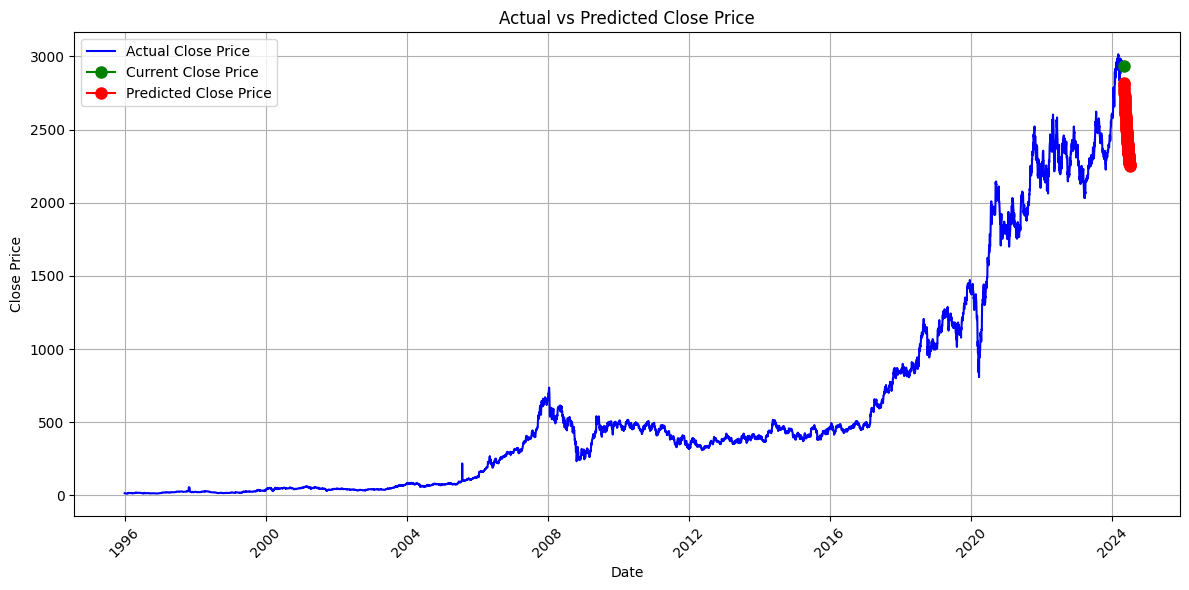

In [37]:
def predict_future_prices(model, data, look_back, num_days):
    last_sequence = data[-look_back:]  # Get the last sequence of known data
    predicted_prices = []
    for _ in range(num_days):
        prediction = model.predict(last_sequence.reshape(1, look_back, 1))  # Predict next day's price
        predicted_prices.append(prediction[0, 0])  # Append predicted price to list
        last_sequence = np.append(last_sequence[1:], prediction[0])  # Update last sequence with new prediction
    return scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))[:, 0]

# Predict future prices for the next 20 days
num_days = 60  # Change this value to predict a different number of days into the future
predicted_prices = predict_future_prices(model, scaled_data, look_back, num_days)

# Plot actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], scaler.inverse_transform(scaled_data), label='Actual Close Price', color='blue')
plt.plot(data['Date'].iloc[-1:], scaler.inverse_transform(scaled_data)[-1:], marker='o', markersize=8, color='green', label='Current Close Price')
plt.plot(pd.date_range(start=data['Date'].iloc[-1], periods=num_days+1, freq='D')[1:], predicted_prices, marker='o', markersize=8, color='red', label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
predicted_prices

array([2819.105 , 2808.804 , 2789.5425, 2768.0784, 2747.9758, 2730.457 ,
       2715.3474, 2701.9238, 2689.4219, 2677.2766, 2665.1765, 2653.0164,
       2640.8186, 2628.6626, 2616.6323, 2604.7932, 2593.184 , 2581.82  ,
       2570.7004, 2559.816 , 2549.155 , 2538.7068, 2528.4612, 2518.4114,
       2508.551 , 2498.8757, 2489.3809, 2480.0615, 2470.9138, 2461.9333,
       2453.1155, 2444.455 , 2435.949 , 2427.592 , 2419.3801, 2411.3098,
       2403.3774, 2395.5786, 2387.9106, 2380.3694, 2372.952 , 2365.6553,
       2358.4763, 2351.4119, 2344.4595, 2337.616 , 2330.879 , 2324.2458,
       2317.7136, 2311.281 , 2304.9446, 2298.7024, 2292.5527, 2286.4927,
       2280.5208, 2274.635 , 2268.8333, 2263.1135, 2257.4744, 2251.9136],
      dtype=float32)

In [39]:
model.save('RELIANCE_NS.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
import joblib
joblib.dump(scaler, 'RELIANCE_NS_minmax_scaler.pkl')

['RELIANCE_NS_minmax_scaler.pkl']